In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os

In [20]:
import pims
import pySPM as spm 
import trackpy as tp
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        self.filenames = glob.glob(filename_pattern)
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_plane().pixels for s in self.scans])
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype

molecule_size = 13
min_mass = 2.0
min_size = 1.5
max_ecc = 0.3 
min_sep = None
if False:
    frames = SXMReader("data_50VG/*.sxm")
if True:
    frames = SXMReader("data_60VG/*.sxm")
if False:
    frames = SXMReader("data_40VG/*.sxm")
if False:
    frames = SXMReader("data_high_density/*.sxm")
if False:
    frames = SXMReader("data_hole_closing/*.sxm")
    molecule_size = 9 

#print(frames[0])

#plt.imshow(frames[7])

In [3]:
"""
f = tp.locate(frames[7], molecule_size, minmass=1)
tp.annotate(f, frames[7])

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
"""

f = tp.batch(frames[:], molecule_size, minmass=1, separation=min_sep)
#tp.quiet()  # Turn off progress reports for best performance

Frame 28: 92 features


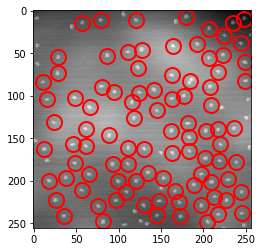

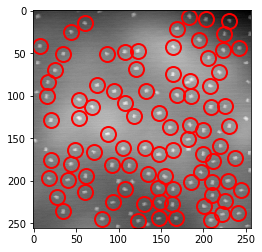

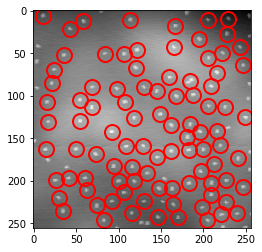

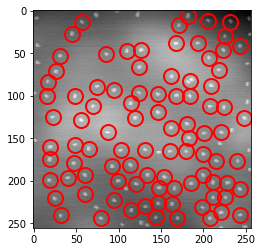

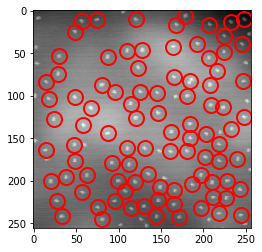

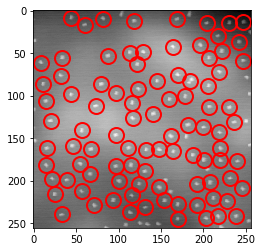

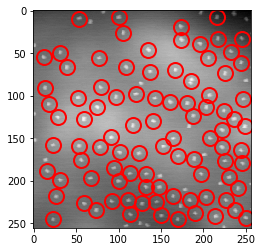

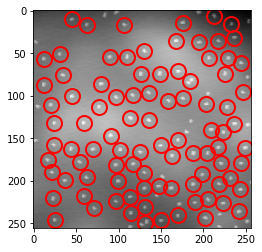

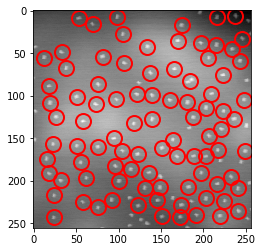

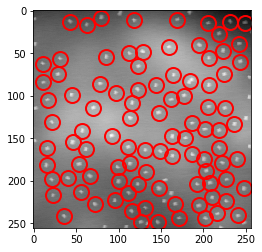

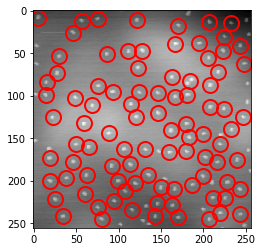

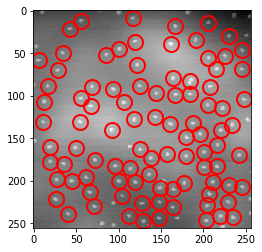

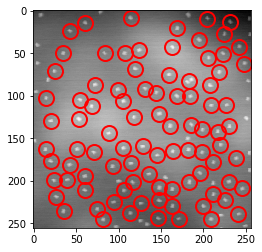

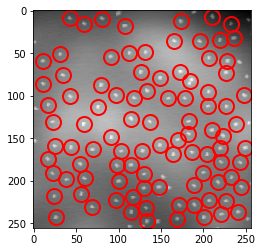

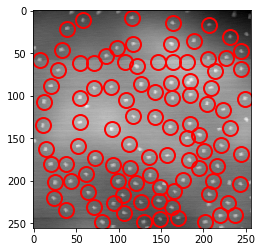

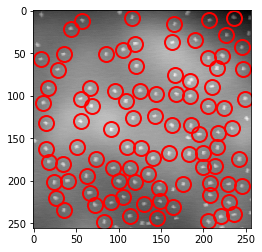

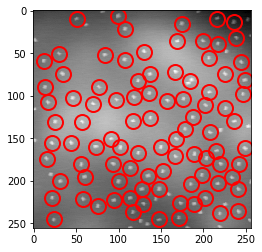

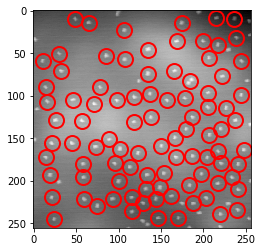

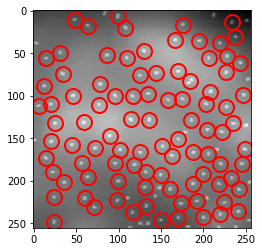

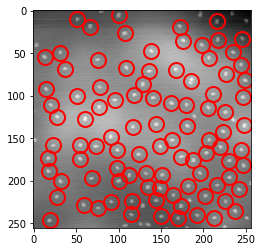

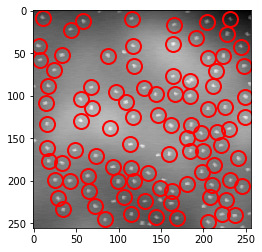

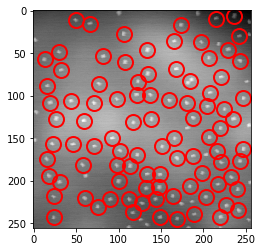

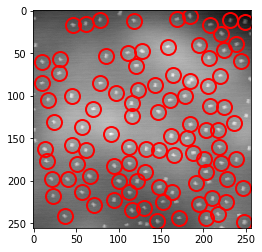

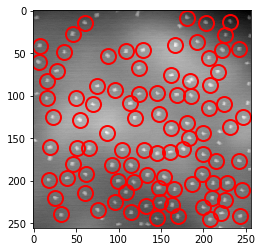

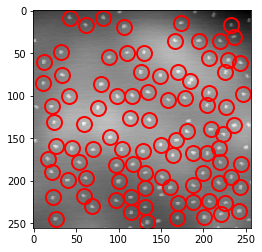

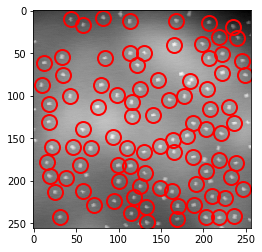

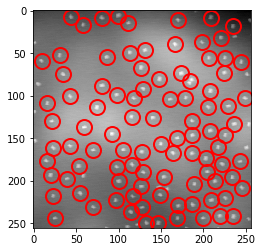

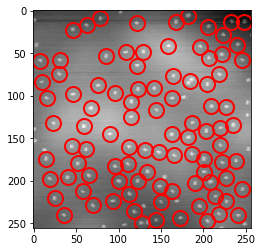

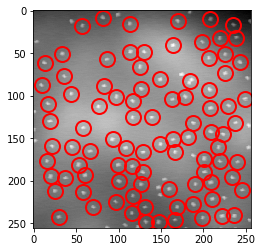

In [4]:
plt.figure()

for i,frame in enumerate(frames):
    tp.annotate(f[f['frame']==i], frame)

Frame 28: 92 trajectories present.


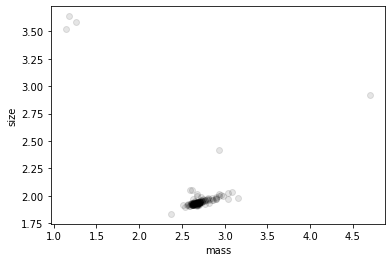

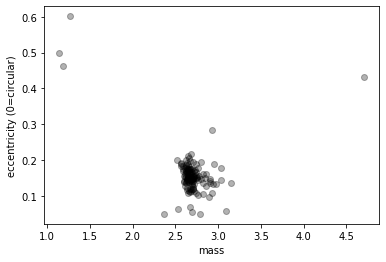

In [5]:
t = tp.link(f, search_range=50, adaptive_stop=5, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [6]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc))]
t2 = tp.filter_stubs(t, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 135
After: 135


/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


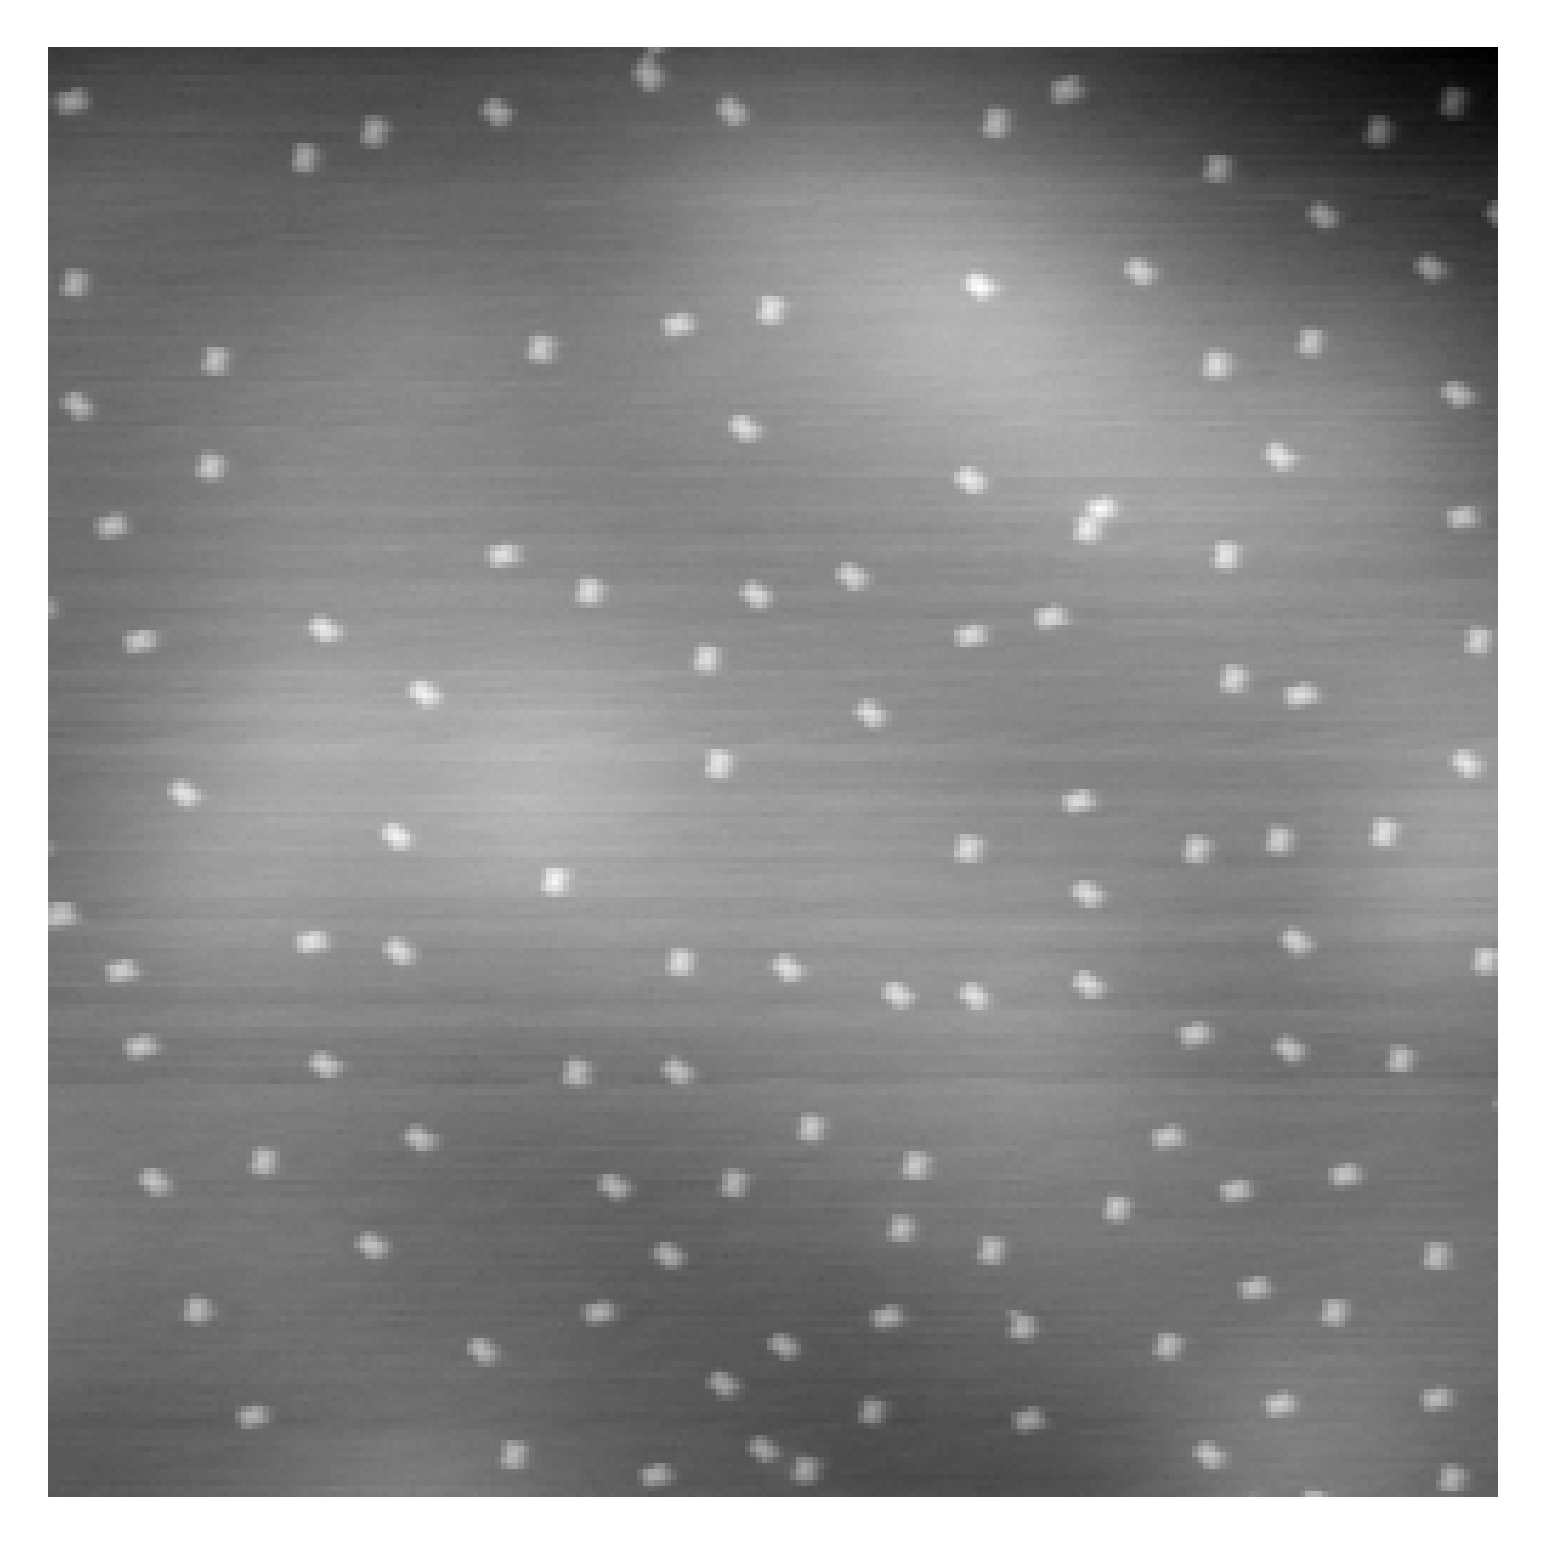

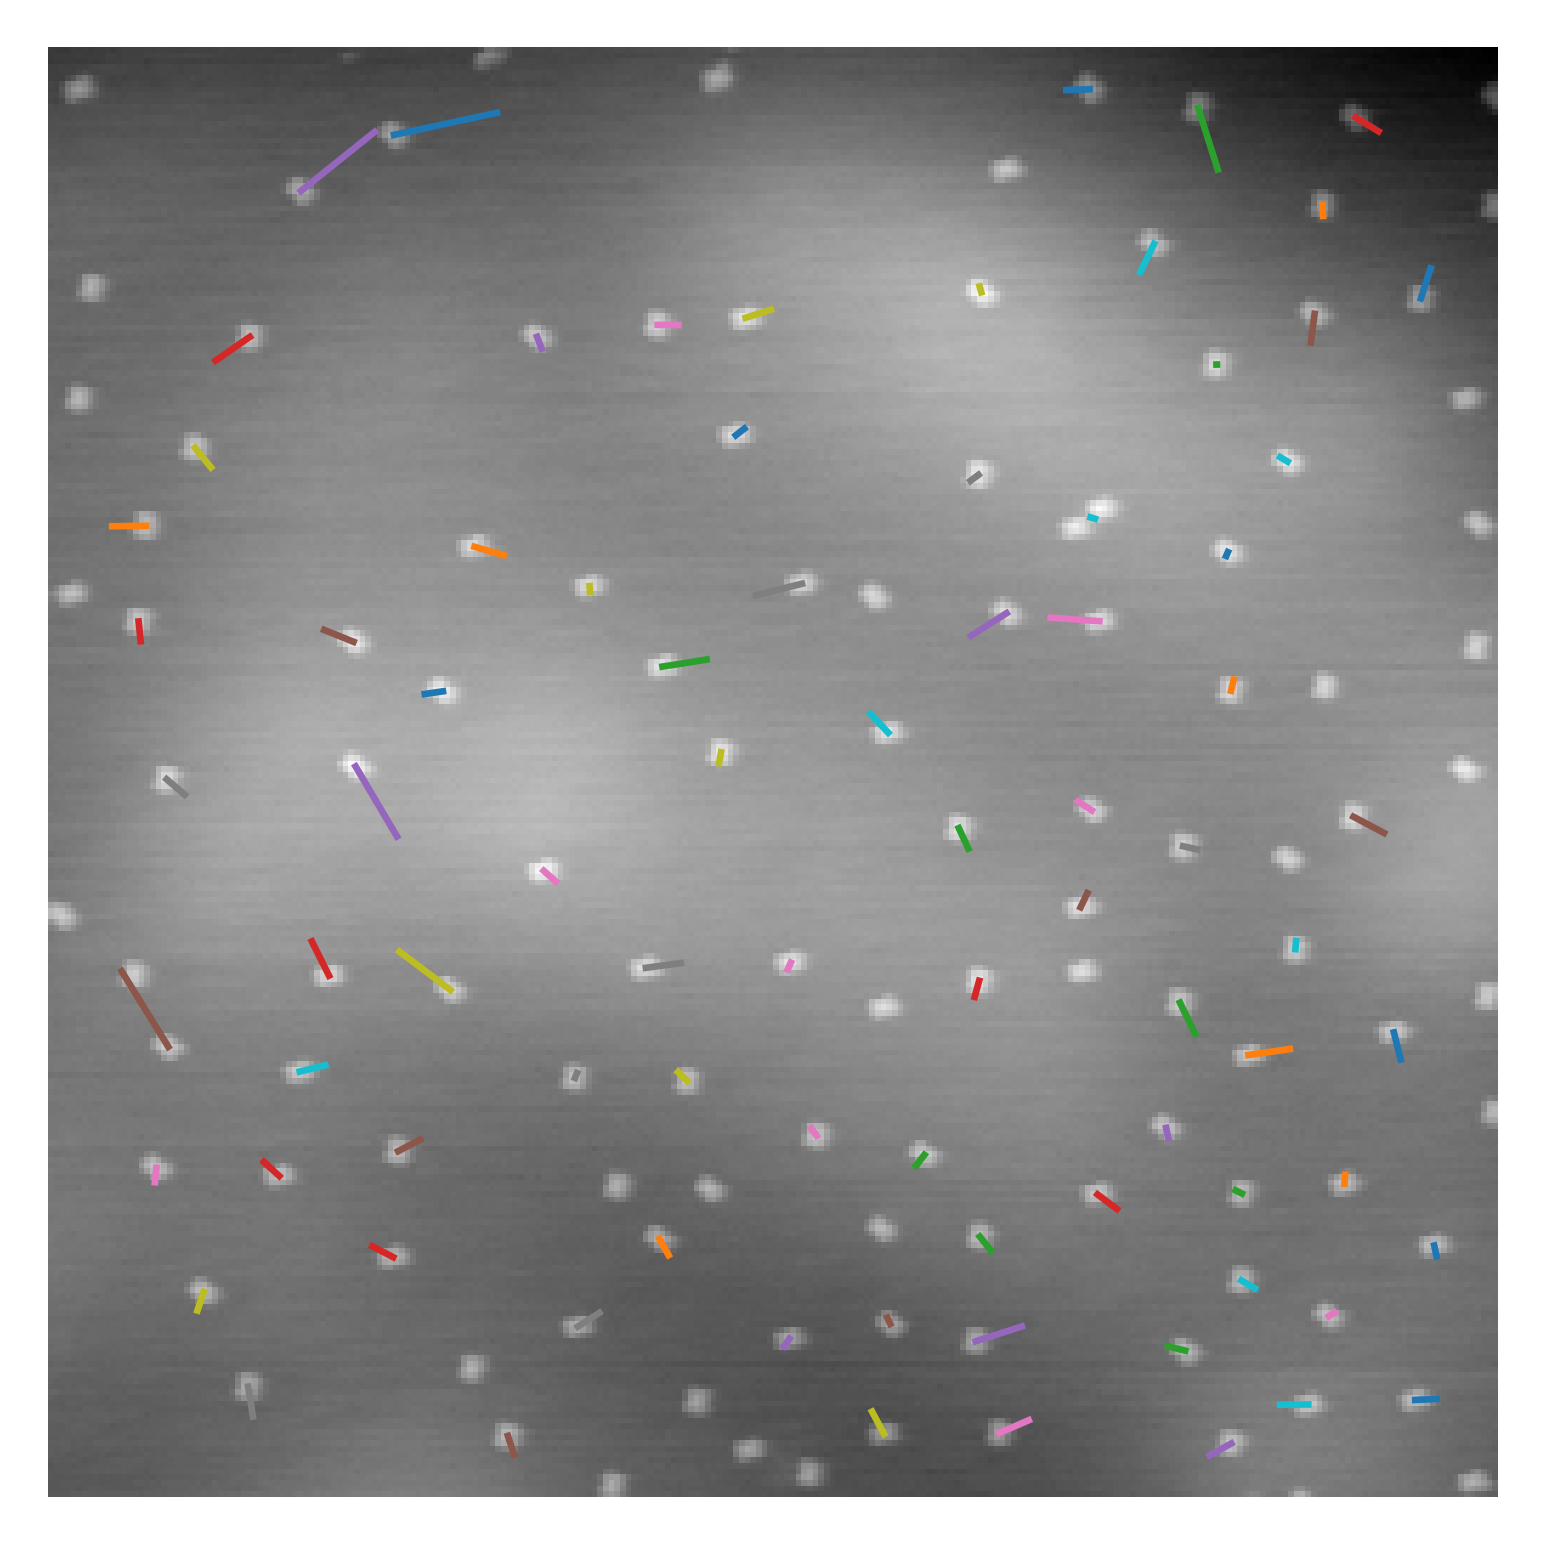

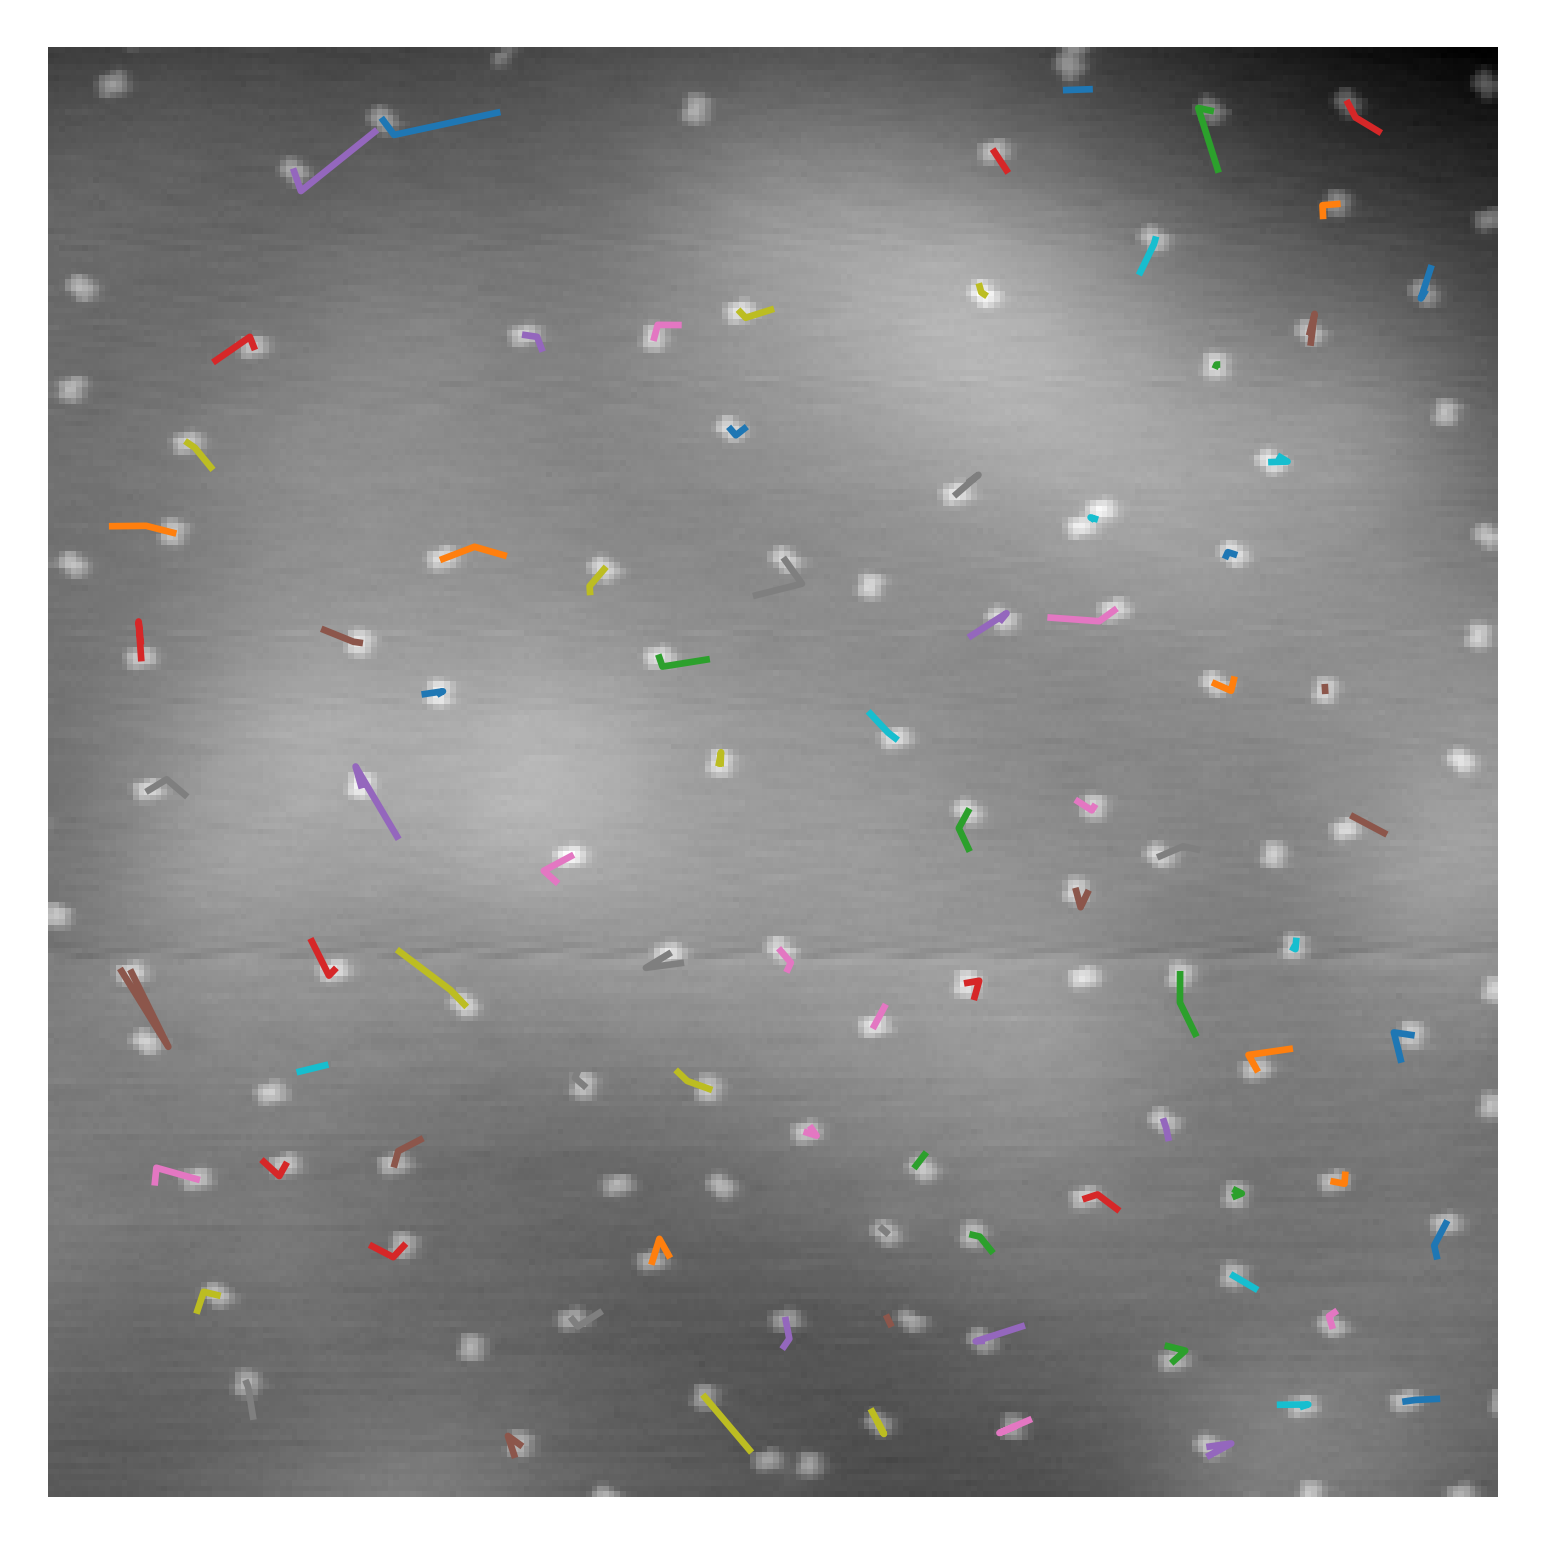

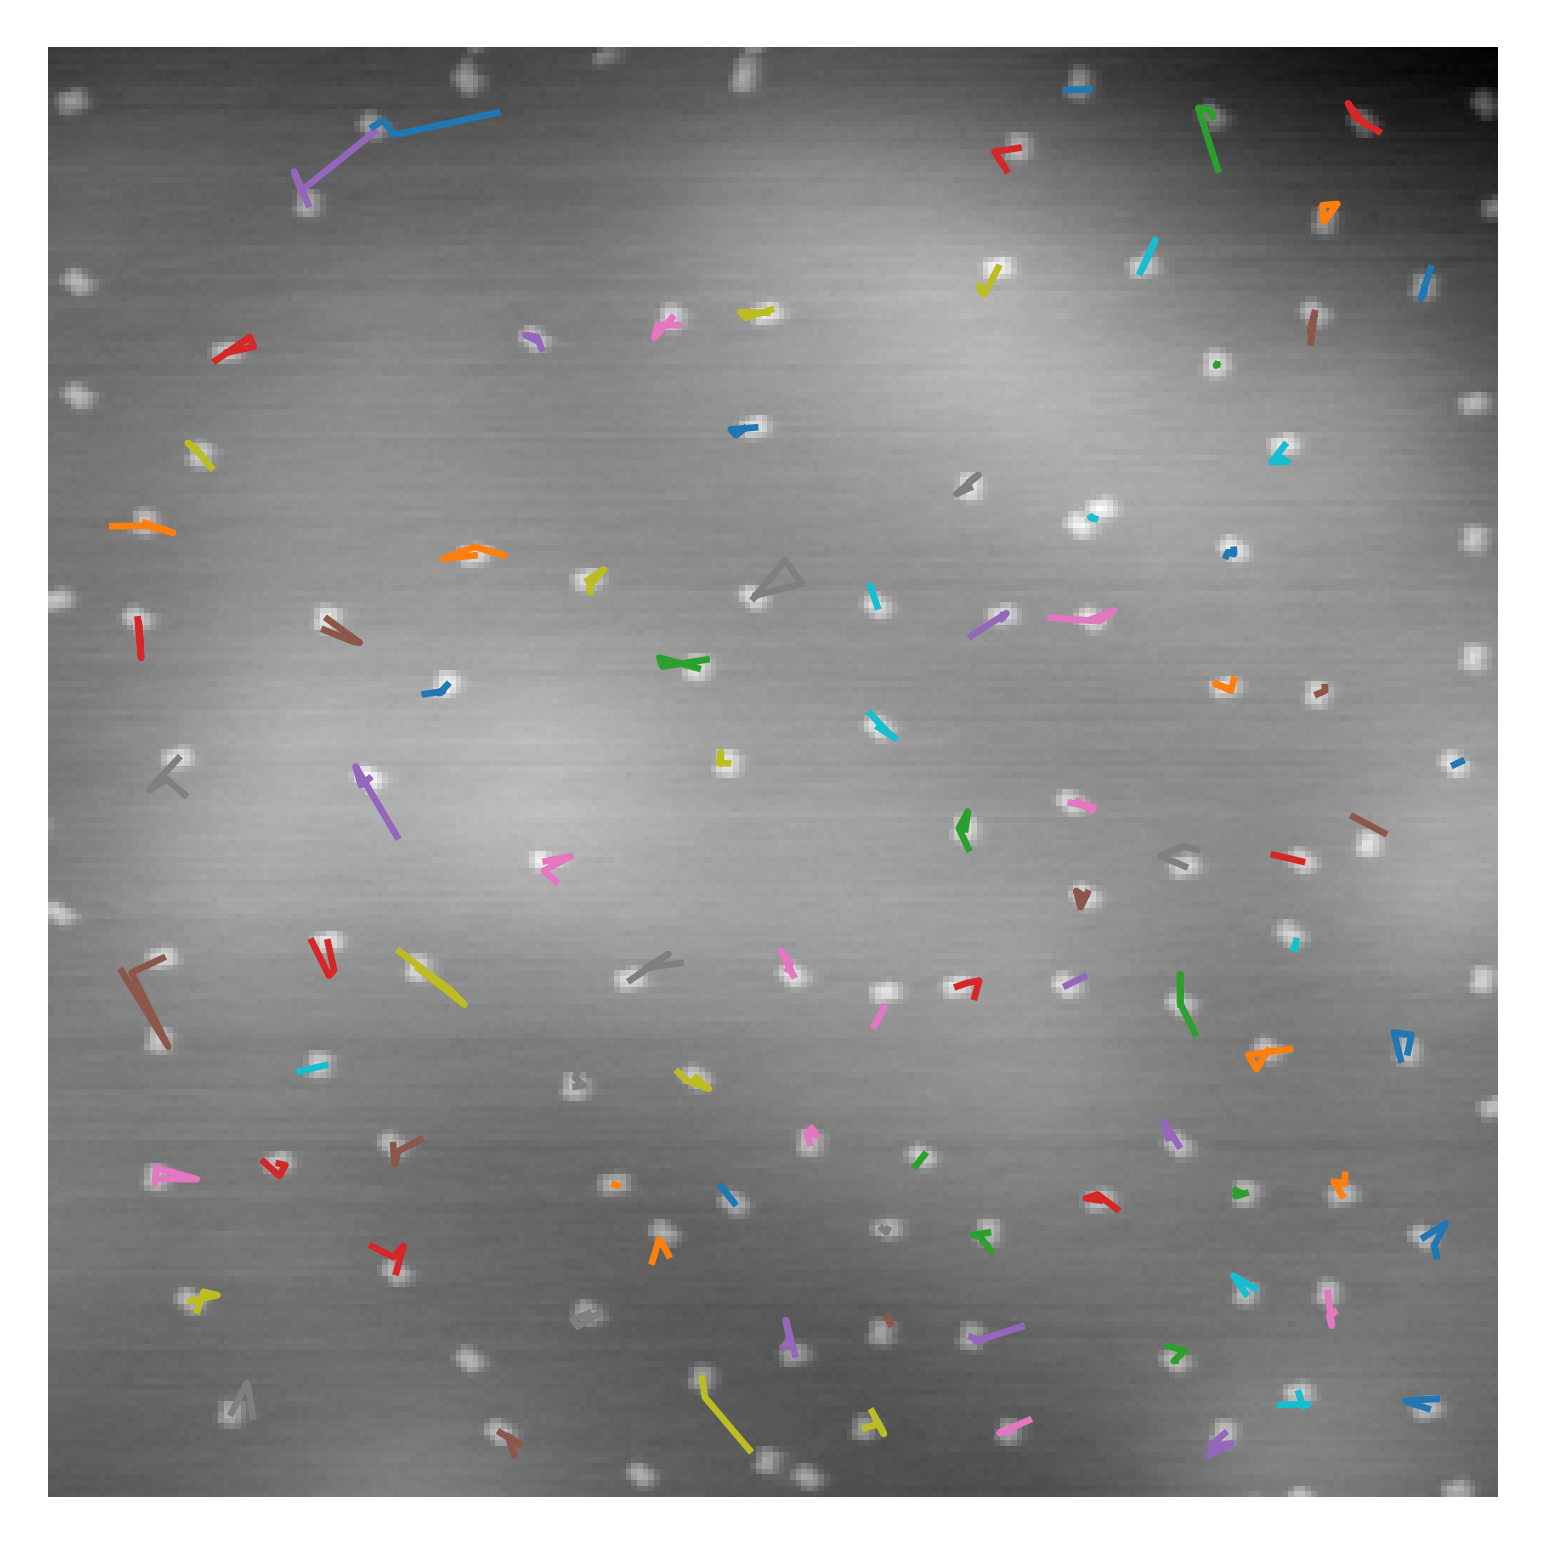

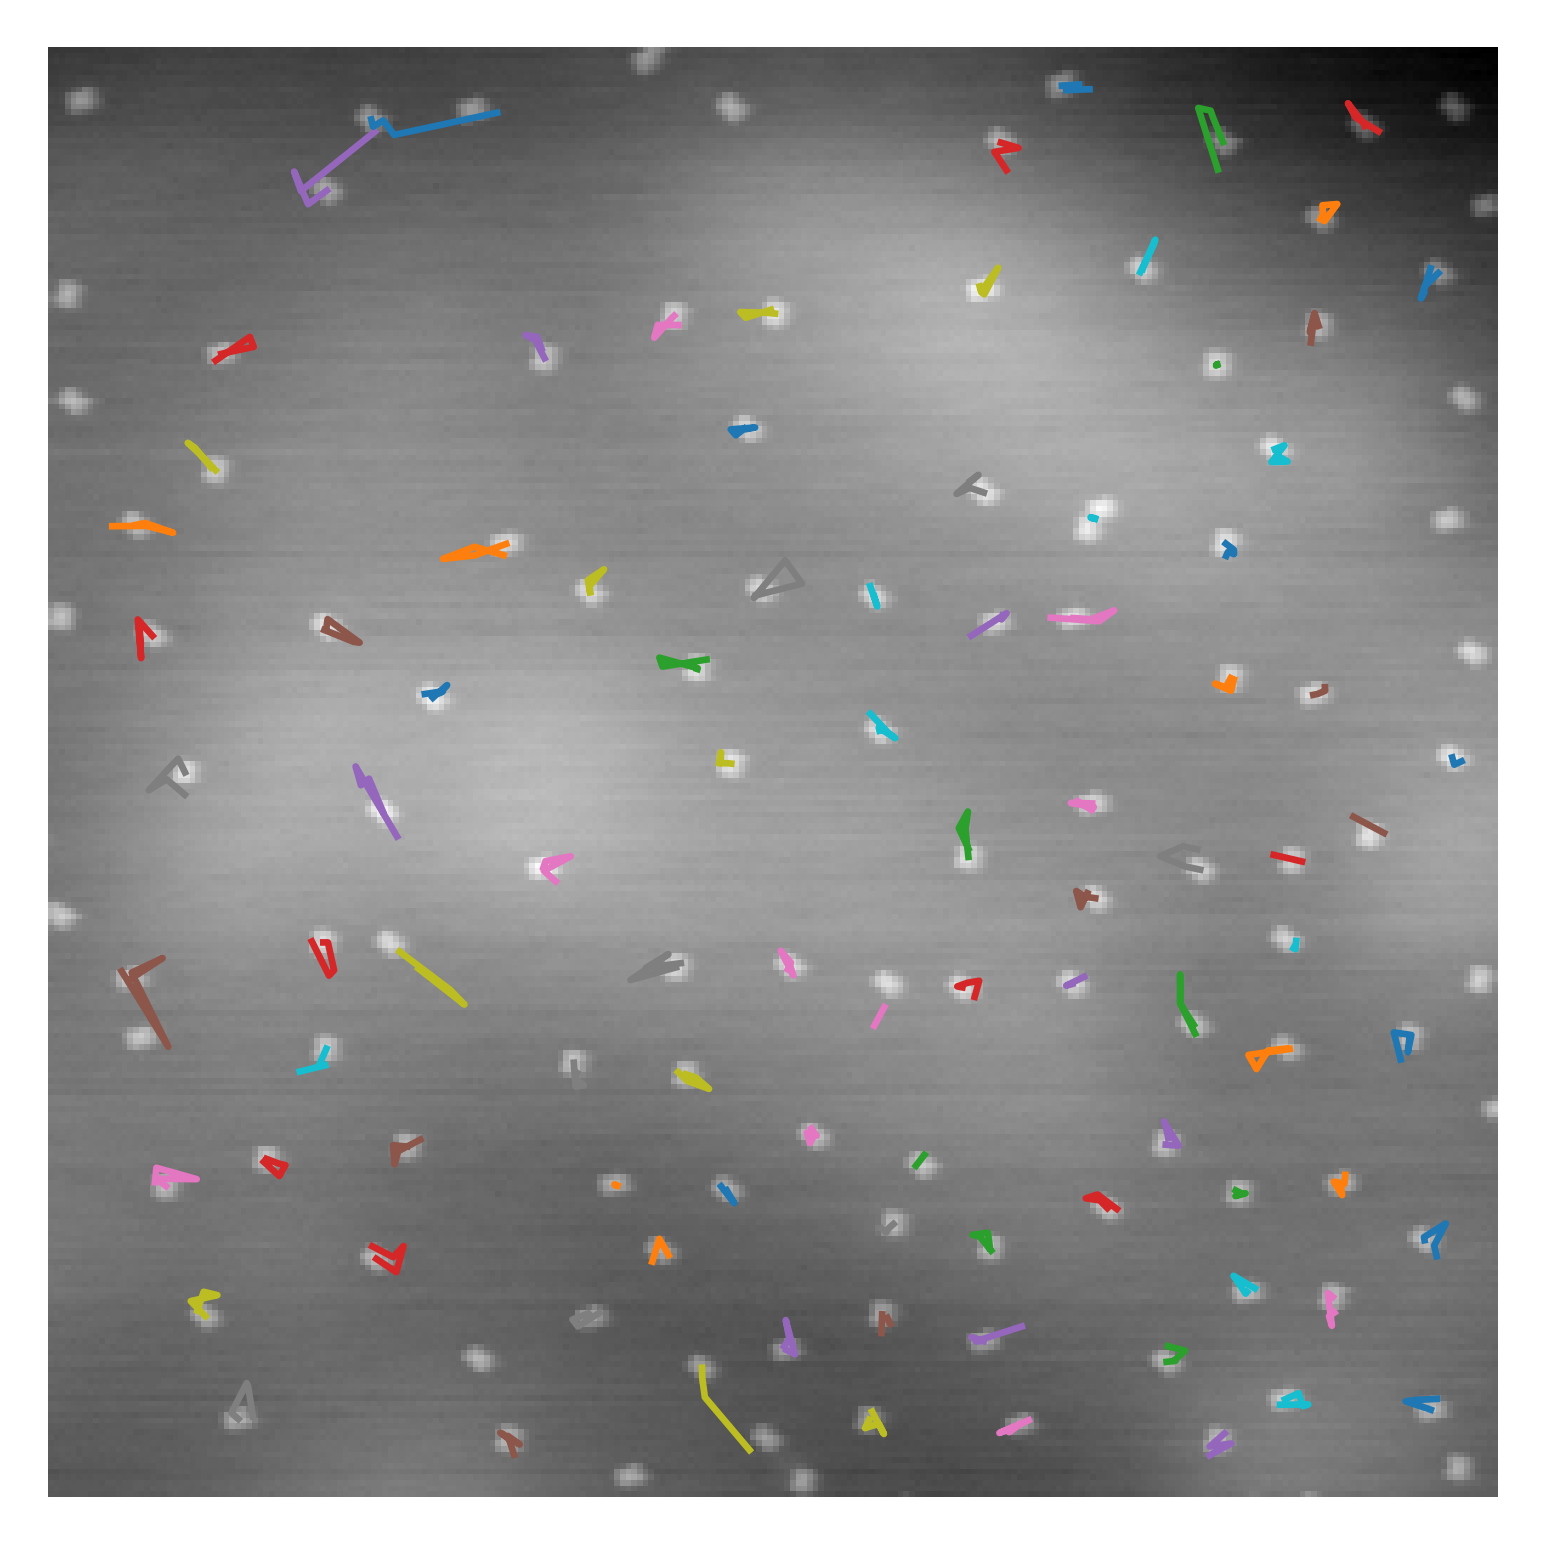

Error in callback <function flush_figures at 0x7f8da96662f0> (for post_execute):


KeyboardInterrupt: 

In [7]:
#for i,frame in enumerate(frames):
#    fig=plt.figure(dpi=480)
#    ax1=plt.axes(frameon=False)
#    tp.plot_traj(t2[t2['frame']<=i], superimpose=frame, ax=ax1);
#    plt.axis('off')
#     fig.savefig('gif_60VG/plot'+'{0:03}'.format(i)+'.png', bbox_inches='tight')

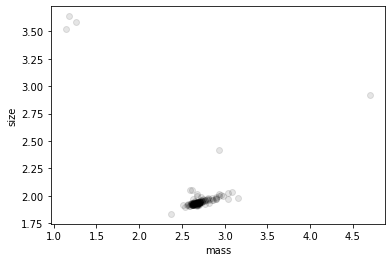

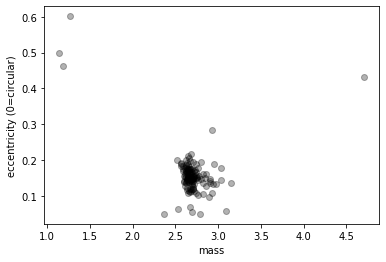

In [8]:
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [9]:
plt.figure()
#tp.plot_traj(t2, superimpose=frames[0]);
#tp.plot_traj(t2[t2['particle']==37], superimpose=frames[0]);

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

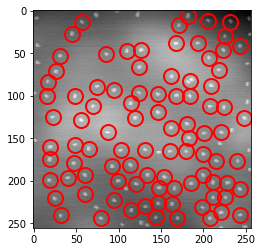

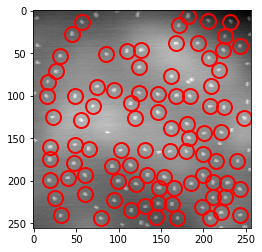

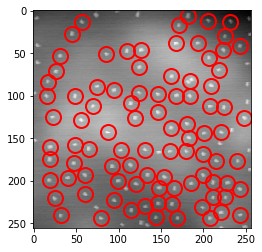

In [10]:
frame_n=3
tp.annotate(f[f['frame'] == frame_n], frames[frame_n])
tp.annotate(t1[t1['frame'] == frame_n], frames[frame_n])
tp.annotate(t2[t2['frame'] == frame_n], frames[frame_n])

In [11]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
print(d)

              y         x
frame                    
1     -0.343229 -0.511673
2     -0.667899 -0.724649
3     -0.434327 -0.710032
4     -0.249668 -0.372556
5     -0.310945  0.033426
6      0.685055  0.547075
7      0.009205  0.048307
8      0.183767  0.551927
9     -0.264010 -0.477924
10    -0.400677 -0.632075
11    -0.118089 -1.472539
12    -0.727952 -1.015108
13    -0.139406  0.258863
14    -0.002668 -1.131988
15    -0.032346 -0.680183
16     0.719729  0.188568
17     0.532596  0.336344
18     0.169532  0.995808
19     1.805038  1.653316
20     0.700231  0.372142
21     0.160246  0.739840
22    -0.099053  0.558205
23    -0.340904  0.223298
24    -0.028480  0.998489
25     0.045573  0.734884
26     0.038151  0.894108
27    -0.226924  0.090265
28     0.189352  0.796782


bad: [0, 2, 21, 25, 45, 52, 67, 69, 72, 107, 110, 125, 129, 130, 133]


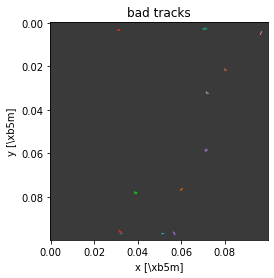

good: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 108, 111, 112, 113, 115, 118, 119, 120, 121, 122, 126, 127, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 108, 111, 112, 113, 115, 118, 119, 120, 121, 122, 126, 127]


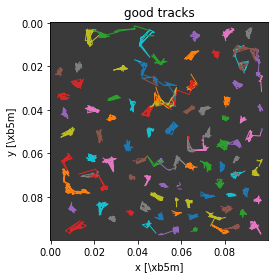

                   1             3         4             5         6    \
lag time [s]                                                             
1.0           0.000003  5.635733e-06  0.000004  4.759378e-06  0.000002   
2.0           0.000004  3.629596e-06  0.000004  5.736851e-06  0.000002   
3.0           0.000004  5.856759e-06  0.000004  5.935085e-06  0.000002   
4.0           0.000004  7.184669e-06  0.000003  3.430563e-06  0.000002   
5.0           0.000004  8.356140e-06  0.000004  3.104790e-06  0.000003   
6.0           0.000005  8.034723e-06  0.000003  5.583905e-06  0.000002   
7.0           0.000005  9.049892e-06  0.000005  5.024411e-06  0.000003   
8.0           0.000003  8.363694e-06  0.000005  4.855848e-06  0.000003   
9.0           0.000004  5.934803e-06  0.000005  3.997572e-06  0.000003   
10.0          0.000005  6.457911e-06  0.000005  4.647455e-06  0.000003   
11.0          0.000004  4.608928e-06  0.000005  4.117629e-06  0.000003   
12.0          0.000003  5.787607e-06  

In [12]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) > (2.0e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#im = im.T[movement_filter].T 
print(im)

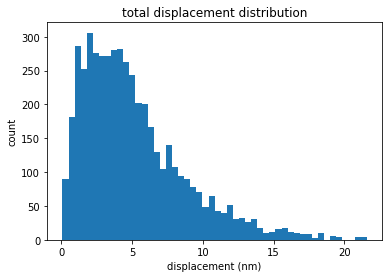

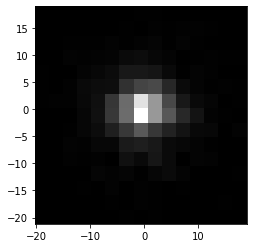

<Figure size 432x288 with 0 Axes>

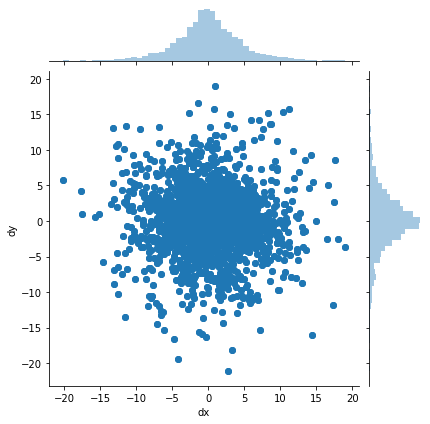

In [13]:
displacements = np.concatenate(paths)
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure();
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
g = sns.jointplot(x="dx", y="dy", data=displacement_df)

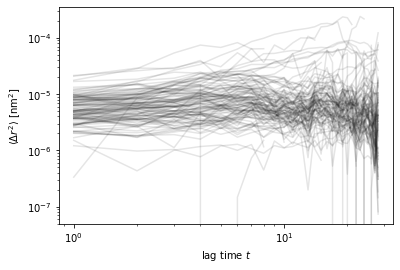

In [14]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

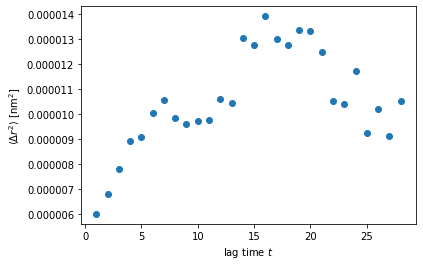

In [19]:
em = tp.emsd(tm, frames.meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));

frame_id = 0
filename = frames.filenames[frame_id]
base_path = filename[:filename.find('/')]
path = os.path.join("output", base_path)
if not os.path.exists(path):
    os.makedirs(path)
fig.savefig(os.path.join(path, 'diffusion.png'))

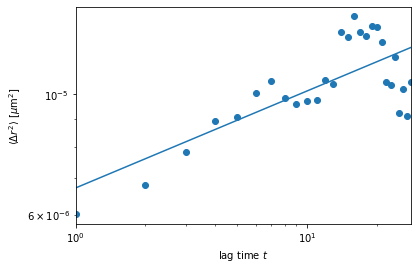

n         A
msd  0.178854  0.000007

In [16]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

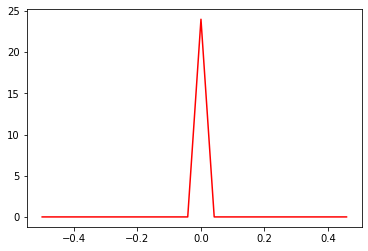

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


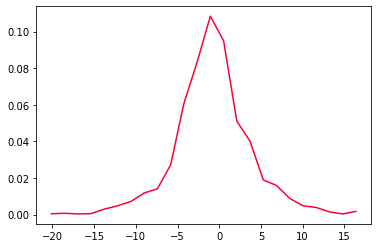

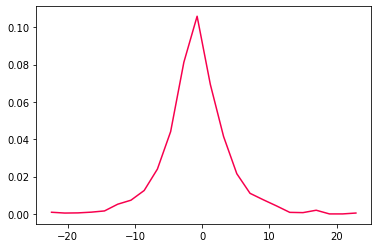

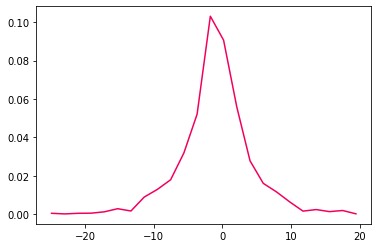

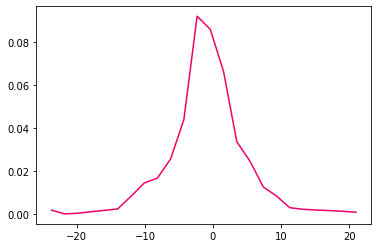

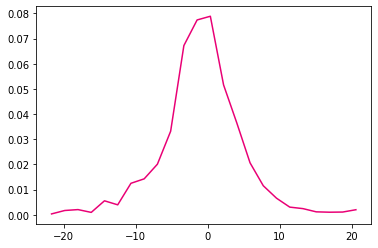

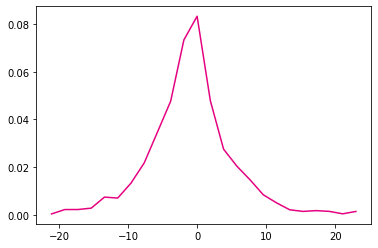

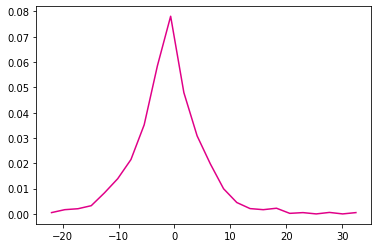

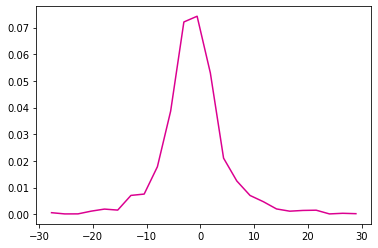

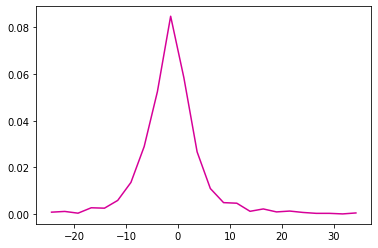

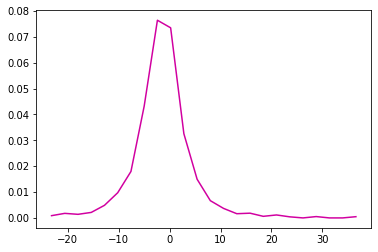

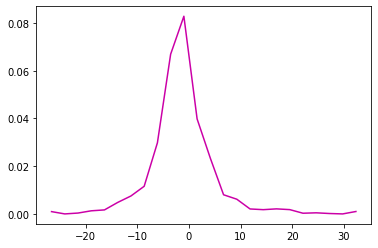

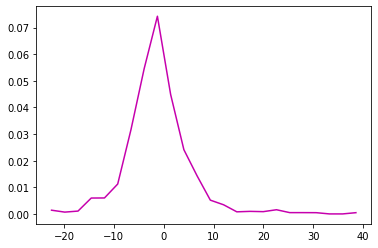

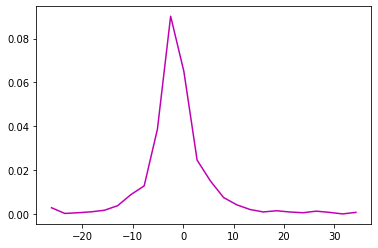

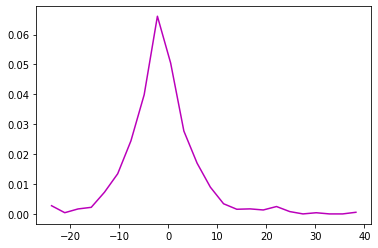

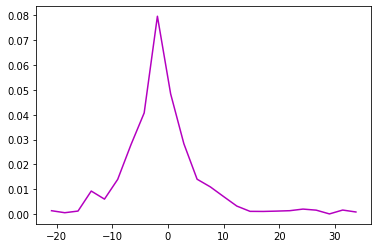

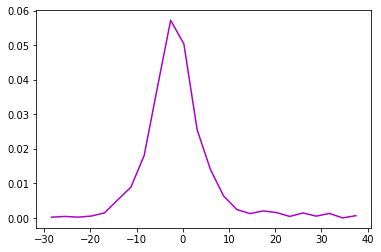

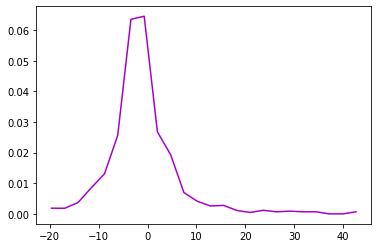

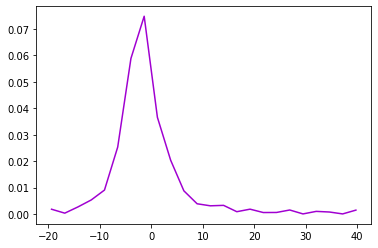

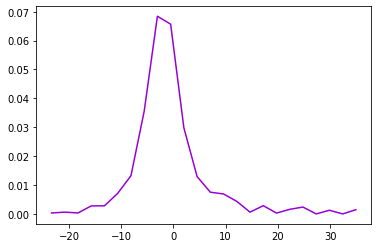

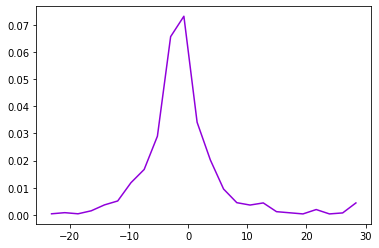

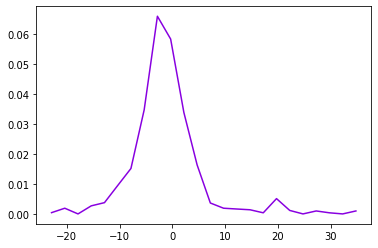

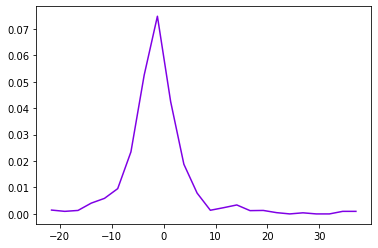

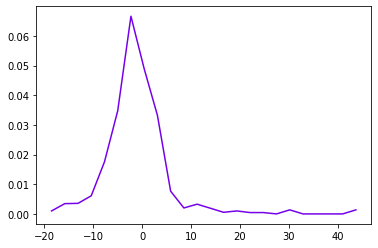

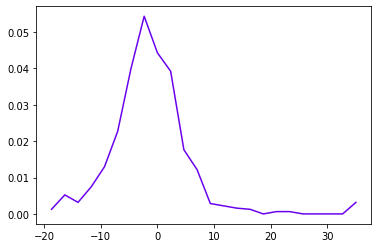

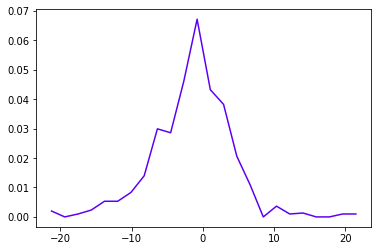

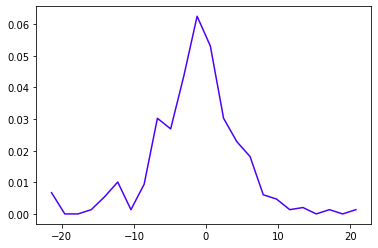

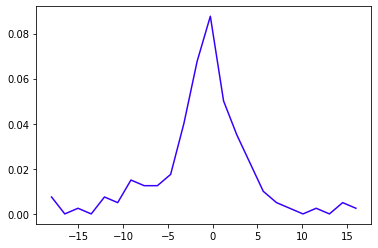

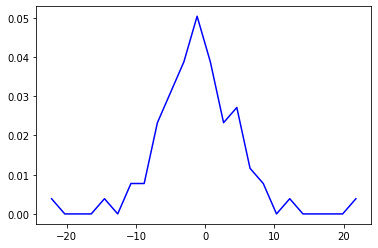

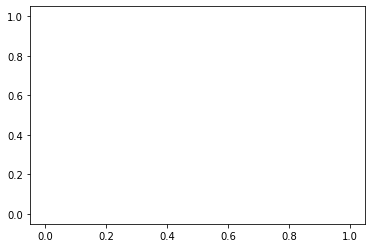

In [17]:
from scipy.optimize import curve_fit
pos = t3.set_index(['frame','particle'])['x'].unstack()
def multiple_gaussian(x, *params):
    y = np.zeros_like(x)
    mu = 0
    for i in range(0, len(params), 3):
        mu += params[i]
        A = params[i+1]
        sigma = params[i+2]
        y = y + A*np.exp( -0.5*((x - mu)/sigma)**2)
    return y
sigmas = []
c1 = np.array((1,0,0))
c2 = np.array((0,0,1))
gamma = 2.2 #sRGB color space gamma
c1_linear = c1**gamma
c2_linear = c2**gamma
def lerp(a, b, t):
    return a*(1-t)+b*t
start_frame = 0
end_frame = max(tm['frame'])
for time in range(start_frame, end_frame+1):
    vh = tp.motion.vanhove(pos, time, ensemble=True)
    #guess = [0, 100, 0.01]
    #popt, pcov = curve_fit(multiple_gaussian, vh.index, vh.to_list(), p0=guess, bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
    #mu = popt[0]
    #A = popt[1]
    #sigma = popt[2]
    #sigmas.append(sigma)
    ##print("peak center:", mu)
    ##print("peak height:", A)
    ##print("peak width:", sigma)
    color_linear = lerp(c1_linear, c2_linear, (time-start_frame)/(end_frame-start_frame))
    color = color_linear**(1/gamma)
    ##plt.subplot(211)
    plt.plot(vh, c=color)
    #x = np.linspace(min(vh.index), max(vh.index), 200)
    ##plt.subplot(212)
    #plt.plot(x, multiple_gaussian(x, *popt), c=color)
    plt.show()
plt.plot(sigmas)